In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
pd.set_option("max_columns" , None)
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import optuna

In [2]:
store = pd.read_csv("store.csv")
df = pd.read_csv("rossman.csv")

In [3]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


#### About the data 
*
*
*
###### Id - Index
###### Store - Mağaza No
###### Sales - Günlük Satışlar
###### Customers - Müşteri Sayısı
###### Open - Mağaza açık mı?kapalı mı ? (0 ve 1 ikili değişken)
###### StateHoliday - Eyalet Tatili (a : resmi tatil  b : paskalya   c : Yılbaşı  0 : tatil yok)
###### SchoolHoliday - Okul tatili ( 0 ve 1 ikili değişken)
###### StoreType - a : sıradan ürünler, b : ekstra ürünler, c : en fazla çeşidin olduğu ürünler.
###### CompetitionDistance - En yakın rakip mağazanın uzaklığı
###### CompetitionOpenSince(Month/Year) - En yakın rakip mağazanın açılış ay ve yılı
###### Promo - Mağazanın promosyon ürünü olup olmadığı.(0 ve 1 ikili değişken)
###### Promo2 - Mağazanın promosyona katılıp katılmadığı.(0 ve 1 ikili değişken)
###### Promo2Since(Year/Week) --> Eğer Promo2 1 ise Promo2'ye başladığı yıl ve yılın haftası.
###### PromoInterval --> Promo2'nin başladığı aylar. ( 3'e ayrılmış cat değişken)

In [5]:
firstdf = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [7]:
df = df.merge(store , how = "left" , on = "Store")
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
def date(data) : 
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Day"] = df.Date.dt.day

In [9]:
date(df)

In [10]:
df["WeekOfYear"] = df.Date.dt.weekofyear
df["SalesPerCustomer"] = df.Sales / df.Customers

In [11]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,SalesPerCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,8.626118


In [12]:
df.nunique()

Store                          1115
DayOfWeek                         7
Date                            942
Sales                         21734
Customers                      4086
Open                              2
Promo                             2
StateHoliday                      5
SchoolHoliday                     2
StoreType                         4
Assortment                        3
CompetitionDistance             654
CompetitionOpenSinceMonth        12
CompetitionOpenSinceYear         23
Promo2                            2
Promo2SinceWeek                  24
Promo2SinceYear                   7
PromoInterval                     3
Year                              3
Month                            12
Day                              31
WeekOfYear                       52
SalesPerCustomer             651408
dtype: int64

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.429727,321.908651,1.0,280.000000,558.00,838.000000,1115.000000
DayOfWeek,1017209.0,3.998341,1.997391,1.0,2.000000,4.00,6.000000,7.000000
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.000000,5744.00,7856.000000,41551.000000
Customers,1017209.0,633.145946,464.411734,0.0,405.000000,609.00,837.000000,7388.000000
Open,1017209.0,0.830107,0.375539,0.0,1.000000,1.00,1.000000,1.000000
Promo,1017209.0,0.381515,0.485759,0.0,0.000000,0.00,1.000000,1.000000
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.000000,0.00,0.000000,1.000000
CompetitionDistance,1014567.0,5430.085652,7715.323700,20.0,710.000000,2330.00,6890.000000,75860.000000
CompetitionOpenSinceMonth,693861.0,7.222866,3.211832,1.0,4.000000,8.00,10.000000,12.000000
CompetitionOpenSinceYear,693861.0,2008.690228,5.992644,1900.0,2006.000000,2010.00,2013.000000,2015.000000


### Data Vizualization

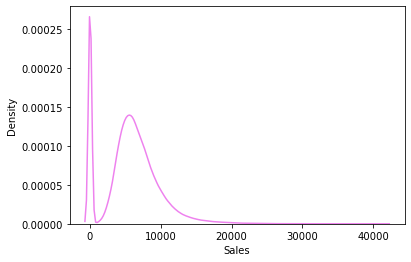

In [14]:
sns.distplot(df.Sales , hist = False , color = "violet");

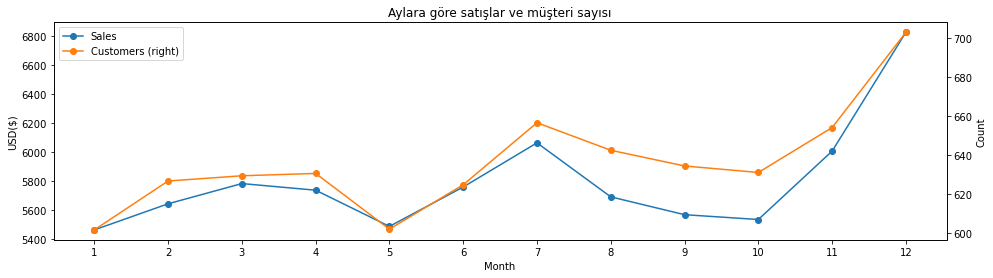

In [15]:
ax = df.groupby("Month")[["Sales" ,"Customers"]].mean().plot(secondary_y = ["Customers"] ,
                                                            figsize = (16,4) , marker = "o")

ax.set_ylabel("USD($)")
ax.right_ax.set_ylabel("Count")
ax.set_xticks(range(1,13))
plt.title("Aylara göre satışlar ve müşteri sayısı");

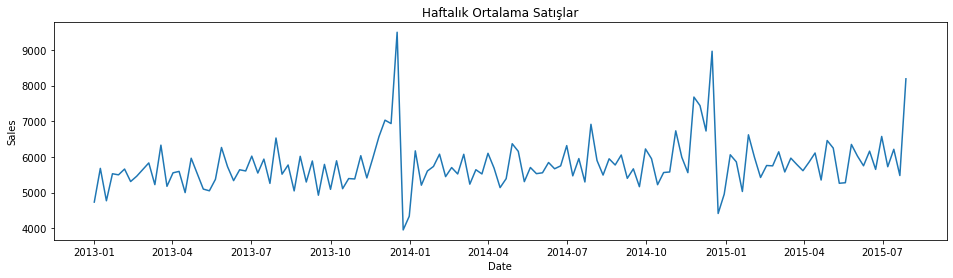

In [17]:
plt.figure(figsize = (16, 4))
data_train_sales = df[["Date", "Sales"]]
data_train_sales_1 = data_train_sales.groupby(pd.Grouper(key = "Date", freq = "7D")).mean()
ax = sns.lineplot(x = data_train_sales_1.index, y = data_train_sales_1["Sales"])
ax.set_title("Haftalık Ortalama Satışlar")
plt.show()

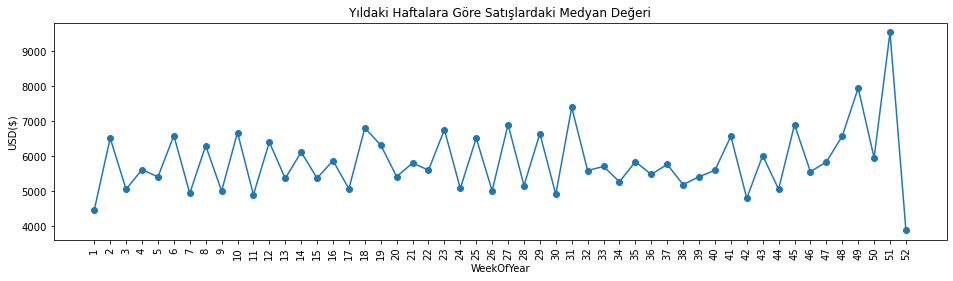

In [18]:
df.groupby("WeekOfYear")["Sales"].median().plot(figsize = (16,4), marker = "o" , xticks = np.arange(1,53), rot = 90)
plt.title("Yıldaki Haftalara Göre Satışlardaki Medyan Değeri")
plt.ylabel("USD($)");

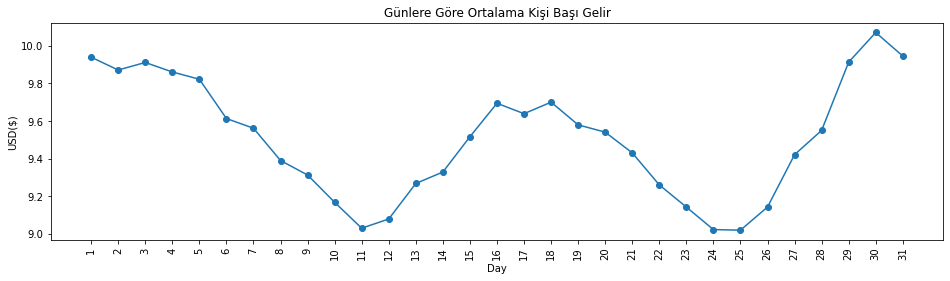

In [20]:
df.groupby("Day")["SalesPerCustomer"].mean().plot(figsize = (16,4) , marker = "o" , xticks = np.arange(1,32), rot = 90)
plt.title("Günlere Göre Ortalama Kişi Başı Gelir")
plt.ylabel("USD($)");

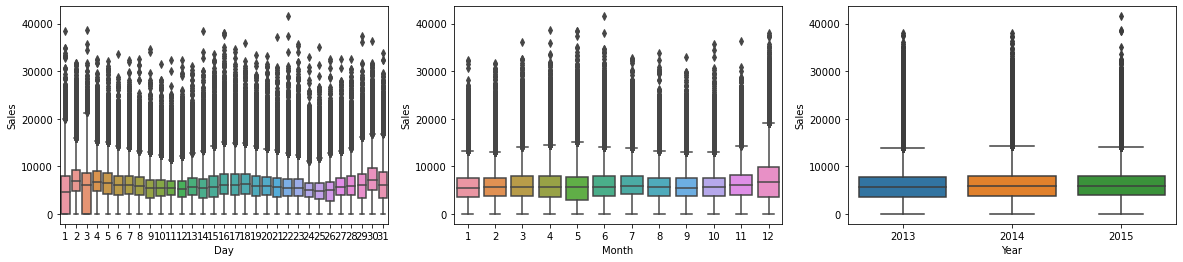

In [23]:
figure , ax = plt.subplots(1,3 , figsize = (20,4))

sns.boxplot(x = "Day" , y = "Sales" , data = df , ax = ax[0])
sns.boxplot(x = "Month" , y = "Sales" , data = df , ax = ax[1])
sns.boxplot(x = "Year" , y = "Sales" , data = df , ax = ax[2])

plt.show()

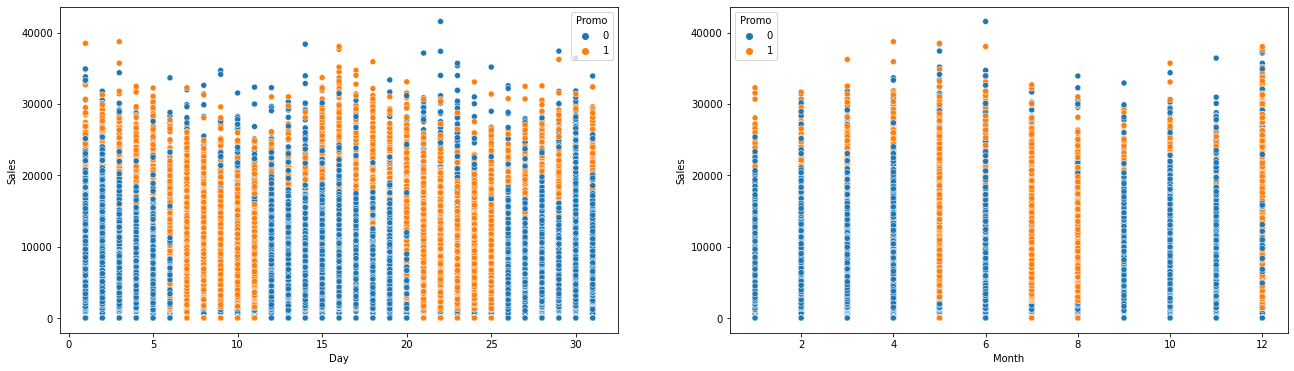

In [24]:
figure , ax = plt.subplots(1,2 , figsize = (22,6))

sns.scatterplot(x = "Day" , y = "Sales" , hue = "Promo" , data = df , ax = ax[0])
sns.scatterplot(x = "Month" , y = "Sales" , hue = "Promo" , data = df , ax = ax[1])

plt.show()

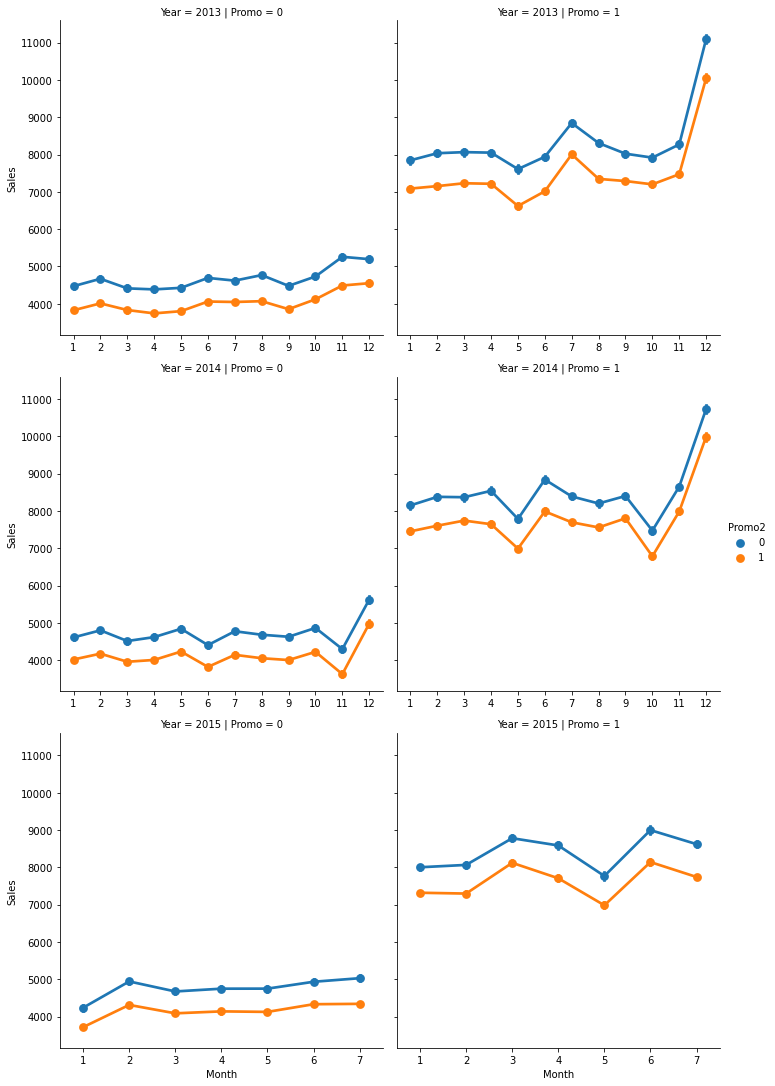

In [25]:
sns.factorplot(data = df, x = "Month", y = "Sales", 
               col = "Promo",
               hue = "Promo2" ,
               row = "Year" ,
               sharex = False);

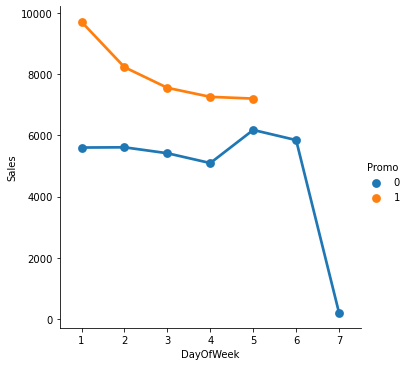

In [26]:
sns.factorplot(data = df , x = "DayOfWeek" , y = "Sales",
              hue = "Promo");

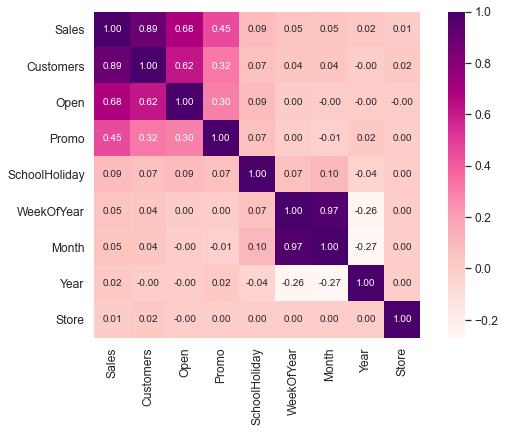

In [27]:
df4matrix = df.drop(["SalesPerCustomer","Promo2SinceWeek",
               "CompetitionOpenSinceYear","CompetitionDistance"] , axis = 1)

corrmatrix = df4matrix.corr()
plt.figure(figsize = (10,6))
columnz = corrmatrix.nlargest(9 , "Sales")["Sales"].index
cm = np.corrcoef(df4matrix[columnz].values.T)
sns.set(font_scale = 1.1)
hm = sns.heatmap(cm , cbar = True , annot = True , square = True ,
                cmap = "RdPu" , fmt = ".2f" , annot_kws = {"size" : 10} ,
                 yticklabels = columnz.values , xticklabels = columnz.values)
plt.show()

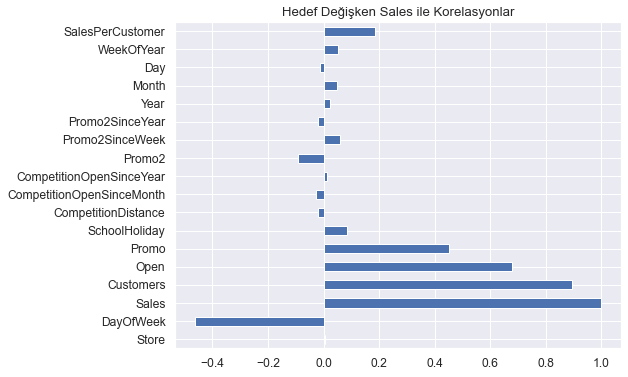

In [29]:
plt.figure(figsize = (8,6))

df.corr()["Sales"].plot(kind = "barh" , grid = True)
plt.title("Hedef Değişken Sales ile Korelasyonlar");

### Missing Values

In [30]:
df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
SalesPerCustomer             172869
dtype: int64

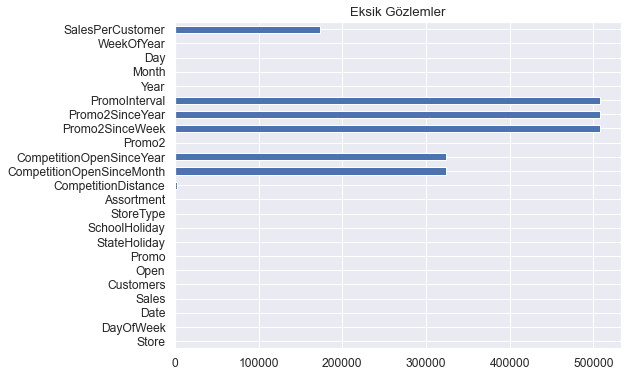

In [33]:
plt.figure(figsize = (8,6))

df.isna().sum().plot(kind = "barh" , grid = True)
plt.title("Eksik Gözlemler");

1 - CompetitionDistance

In [35]:
df["CompetitionDistance"].value_counts()

250.0      11120
50.0        7536
350.0       7536
1200.0      7374
190.0       7352
           ...  
1470.0       758
15700.0      758
3840.0       758
1400.0       758
4460.0       758
Name: CompetitionDistance, Length: 654, dtype: int64

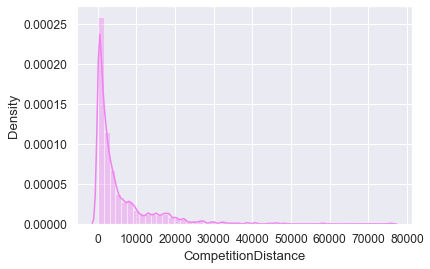

In [37]:
sns.distplot(df.CompetitionDistance , hist = True , color = "violet");

In [38]:
df["CompetitionDistance"].fillna(df["CompetitionDistance"].median() , inplace = True)

2 - CompetitionOpenSinceMonth/Year

###### Modelde kullanmak istemediğim için direkt atıyorum.

In [39]:
df.drop(["CompetitionOpenSinceMonth" , "CompetitionOpenSinceYear"] , axis = 1 , inplace = True)

3 - Promo2SinceWeek/Year

In [40]:
df["Promo2SinceWeek"].value_counts()

14.0    72990
40.0    62598
31.0    39976
10.0    38828
5.0     35818
37.0    32786
1.0     32418
13.0    29820
45.0    29268
22.0    28694
18.0    27318
35.0    22814
9.0     12452
27.0     9626
36.0     9236
48.0     8294
39.0     4732
23.0     4342
44.0     2642
28.0      942
26.0      942
6.0       942
50.0      942
49.0      758
Name: Promo2SinceWeek, dtype: int64

In [41]:
df["Promo2SinceYear"].value_counts()

2011.0    115056
2013.0    110464
2014.0     79922
2012.0     73174
2009.0     65270
2010.0     56240
2015.0      9052
Name: Promo2SinceYear, dtype: int64

In [44]:
df["Promo2SinceWeek"].fillna(0 , inplace = True)
df["Promo2SinceYear"].fillna(0 , inplace = True)

4 - PromoInterval

In [46]:
df["PromoInterval"].value_counts()

Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64

In [47]:
df["PromoInterval"].fillna(0 , inplace = True)

5 - SalesPerCustomer

In [49]:
df["SalesPerCustomer"].fillna(0 , inplace = True)

In [50]:
df.isna().sum()

Store                  0
DayOfWeek              0
Date                   0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
Promo2SinceWeek        0
Promo2SinceYear        0
PromoInterval          0
Year                   0
Month                  0
Day                    0
WeekOfYear             0
SalesPerCustomer       0
dtype: int64

#### Veriyi Modele Hazırlama

In [53]:
df[(df.Open == 1) & (df.Sales == 0)].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,SalesPerCustomer
86825,971,5,2015-05-15,0,0,1,0,0,1,c,a,1140.0,1,14.0,2012.0,"Mar,Jun,Sept,Dec",2015,5,15,20,0.0
142278,674,4,2015-03-26,0,0,1,0,0,0,a,a,2640.0,1,31.0,2013.0,"Feb,May,Aug,Nov",2015,3,26,13,0.0
196938,699,4,2015-02-05,0,0,1,1,0,0,a,a,180.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",2015,2,5,6,0.0
322053,708,3,2014-10-01,0,0,1,1,0,0,c,c,11470.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct",2014,10,1,40,0.0
330176,357,1,2014-09-22,0,0,1,0,0,0,a,a,2060.0,0,0.0,0.0,0,2014,9,22,39,0.0


In [54]:
print ("Our data set has now {} rows ".format(df.shape[0]))

Our data set has now 1017209 rows 


In [55]:
df = df.drop(df[(df.Open == 1) & (df.Sales == 0)].index)
df = df.reset_index(drop = True)

In [57]:
print ("Our new data set has now {} rows ".format(df.shape[0]))

Our new data set has now 1017155 rows 


In [58]:
df[(df.Open == 0) & (df.Sales == 0)].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,SalesPerCustomer
291,292,5,2015-07-31,0,0,0,1,0,1,a,a,1100.0,0,0.0,0.0,0,2015,7,31,31,0.0
875,876,5,2015-07-31,0,0,0,1,0,1,a,a,21790.0,1,18.0,2015.0,"Feb,May,Aug,Nov",2015,7,31,31,0.0
1406,292,4,2015-07-30,0,0,0,1,0,1,a,a,1100.0,0,0.0,0.0,0,2015,7,30,31,0.0
1990,876,4,2015-07-30,0,0,0,1,0,1,a,a,21790.0,1,18.0,2015.0,"Feb,May,Aug,Nov",2015,7,30,31,0.0
2521,292,3,2015-07-29,0,0,0,1,0,1,a,a,1100.0,0,0.0,0.0,0,2015,7,29,31,0.0


In [59]:
df = df.drop(df[(df.Open == 0) & (df.Sales == 0)].index)
df = df.reset_index(drop = True)

In [60]:
print("Our new data set has now {} rows ".format(df.shape[0]))

Our new data set has now 844338 rows 


In [61]:
df[df.Customers > 7000]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,SalesPerCustomer
825160,817,2,2013-01-22,27190,7388,1,1,0,0,a,a,140.0,0,0.0,0.0,0,2013,1,22,4,3.680292


In [62]:
df[df.Sales > 40000]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,SalesPerCustomer
38929,909,1,2015-06-22,41551,1721,1,0,0,0,a,c,1680.0,1,45.0,2009.0,"Feb,May,Aug,Nov",2015,6,22,26,24.143521


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Store                844338 non-null  int64         
 1   DayOfWeek            844338 non-null  int64         
 2   Date                 844338 non-null  datetime64[ns]
 3   Sales                844338 non-null  int64         
 4   Customers            844338 non-null  int64         
 5   Open                 844338 non-null  int64         
 6   Promo                844338 non-null  int64         
 7   StateHoliday         844338 non-null  object        
 8   SchoolHoliday        844338 non-null  int64         
 9   StoreType            844338 non-null  object        
 10  Assortment           844338 non-null  object        
 11  CompetitionDistance  844338 non-null  float64       
 12  Promo2               844338 non-null  int64         
 13  Promo2SinceWee

In [71]:
df.StateHoliday.value_counts()

0    843428
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

In [70]:
df["StateHoliday"] = df.StateHoliday.replace(0 , "0")

In [72]:
df.loc[df["StateHoliday"] == "a" , "StateHoliday"] = "1"
df.loc[df["StateHoliday"] == "b" , "StateHoliday"] = "1"
df.loc[df["StateHoliday"] == "c" , "StateHoliday"] = "1"
df["StateHoliday"] = df["StateHoliday"].astype(int)

In [73]:
df.StateHoliday.value_counts()

0    843428
1       910
Name: StateHoliday, dtype: int64

In [74]:
df.StoreType.value_counts()

a    457042
d    258768
c    112968
b     15560
Name: StoreType, dtype: int64

In [75]:
lb = LabelEncoder()
lb.fit(list(df["StoreType"].values))
df["StoreType"] = lb.transform(list(df["StoreType"].values))

In [76]:
df.StoreType.value_counts()

0    457042
3    258768
2    112968
1     15560
Name: StoreType, dtype: int64

In [77]:
df.Assortment.value_counts()

a    444875
c    391254
b      8209
Name: Assortment, dtype: int64

In [78]:
lb.fit(list(df["Assortment"].values))
df["Assortment"] = lb.transform(list(df["Assortment"].values))

In [79]:
df.Assortment.value_counts()

0    444875
2    391254
1      8209
Name: Assortment, dtype: int64

In [80]:
df.PromoInterval.value_counts()

0                   423292
Jan,Apr,Jul,Oct     242397
Feb,May,Aug,Nov      97998
Mar,Jun,Sept,Dec     80651
Name: PromoInterval, dtype: int64

In [81]:
df = pd.get_dummies(df , columns = ["PromoInterval"])

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Store                           844338 non-null  int64         
 1   DayOfWeek                       844338 non-null  int64         
 2   Date                            844338 non-null  datetime64[ns]
 3   Sales                           844338 non-null  int64         
 4   Customers                       844338 non-null  int64         
 5   Open                            844338 non-null  int64         
 6   Promo                           844338 non-null  int64         
 7   StateHoliday                    844338 non-null  int32         
 8   SchoolHoliday                   844338 non-null  int64         
 9   StoreType                       844338 non-null  int32         
 10  Assortment                      844338 non-null  int32  

##### Bütün değişkenlerimizi sayısal yaptığımıza göre ML için bağımlı ve bağımsız değişkenleri oluşturabiliriz

In [83]:
x = df.drop(["Date","Sales","Customers","SalesPerCustomer"] , axis = 1)
y = np.log1p(df["Sales"])

In [84]:
x.head()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,1,5,1,1,0,1,2,0,1270.0,0,0.0,0.0,2015,7,31,31,1,0,0,0
1,2,5,1,1,0,1,0,0,570.0,1,13.0,2010.0,2015,7,31,31,0,0,1,0
2,3,5,1,1,0,1,0,0,14130.0,1,14.0,2011.0,2015,7,31,31,0,0,1,0
3,4,5,1,1,0,1,2,2,620.0,0,0.0,0.0,2015,7,31,31,1,0,0,0
4,5,5,1,1,0,1,0,0,29910.0,0,0.0,0.0,2015,7,31,31,1,0,0,0


In [85]:
y[:10]

0    8.568646
1    8.710290
2    9.025816
3    9.546527
4    8.481151
5    8.639765
6    9.638545
7    9.046998
8    9.055556
9    8.879890
Name: Sales, dtype: float64

In [86]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.22 , random_state = 123)

#### XGBoost 

In [88]:
xgb = XGBRegressor().fit(x_train , y_train)

In [89]:
basicmodelpred = xgb.predict(x_test)

In [90]:
np.sqrt(mean_squared_error(y_test , basicmodelpred))

0.16601072109173312

HyperParameter Optimization with Optuna

In [95]:
def objective(trial):
    parameters = {"max_depth" : trial.suggest_int("max_depth" , 1,20) ,
                 "n_estimators" : trial.suggest_categorical("n_estimators" , [100,200,300,400,500,600,700,1000,1200,
                                                                             1500,2000,2500,3000,3500]),
                 "learning_rate" : trial.suggest_categorical("learning_rate" , [0.008,0.004,0.02,0.018,0.012,0.05]),
                 "colsample_bytree" : trial.suggest_discrete_uniform("colsample_bytree" , 0.1,0.9,0.1),
                 "subsample" : trial.suggest_discrete_uniform("subsample" , 0.2,1.0,0.1)
                 }
    model = XGBRegressor(**parameters)
    model.fit(x_train , y_train , eval_set = [(x_test , y_test)] , early_stopping_rounds = 100 ,
              eval_metric = "rmse" , 
              verbose = False)
    
    preds = model.predict(x_test)
    rmse = mean_squared_error(y_test, preds, squared = False)
    return rmse

In [96]:
study = optuna.create_study(direction = "minimize" , study_name = "XGB")
study.optimize(objective , n_trials = 10)
print("Biten deneme sayisi:" , len(study.trials))
print("En iyi deneme:" , study.best_trial.params)

[I 2021-10-02 09:55:58,900] A new study created in memory with name: XGB
[I 2021-10-02 09:56:17,266] Trial 0 finished with value: 3.728051107750786 and parameters: {'max_depth': 2, 'n_estimators': 200, 'learning_rate': 0.004, 'colsample_bytree': 0.1, 'subsample': 0.4}. Best is trial 0 with value: 3.728051107750786.
[I 2021-10-02 10:03:36,854] Trial 1 finished with value: 0.34402424683437494 and parameters: {'max_depth': 2, 'n_estimators': 3500, 'learning_rate': 0.004, 'colsample_bytree': 0.8, 'subsample': 0.5}. Best is trial 1 with value: 0.34402424683437494.
[I 2021-10-02 10:17:21,348] Trial 2 finished with value: 0.14508886727676742 and parameters: {'max_depth': 17, 'n_estimators': 3500, 'learning_rate': 0.018, 'colsample_bytree': 0.1, 'subsample': 0.4}. Best is trial 2 with value: 0.14508886727676742.
[I 2021-10-02 10:36:52,861] Trial 3 finished with value: 0.10866562600419381 and parameters: {'max_depth': 15, 'n_estimators': 2500, 'learning_rate': 0.008, 'colsample_bytree': 0.30000

Biten deneme sayisi: 10
En iyi deneme: {'max_depth': 20, 'n_estimators': 1200, 'learning_rate': 0.018, 'colsample_bytree': 0.4, 'subsample': 0.7}


In [97]:
xgb = XGBRegressor(max_depth = 20 ,n_estimators = 1200 , learning_rate = 0.018 ,
                   colsample_bytree = 0.4 , subsample = 0.7).fit(x_train,y_train)

In [98]:
pred = xgb.predict(x_test)

In [99]:
## Control
np.sqrt(mean_squared_error(y_test , pred))

0.09203092315461736

Feature Importance

In [109]:
importance = pd.DataFrame({"Importance" : xgb.feature_importances_ * 100} ,
                         index = x_train.columns)

In [110]:
importance

,Importance
Store,5.509951
DayOfWeek,3.745429
Open,0.000000
Promo,45.091843
StateHoliday,2.952975
SchoolHoliday,1.231042
StoreType,6.089570
Assortment,4.783447
CompetitionDistance,5.298194
Promo2,4.796904


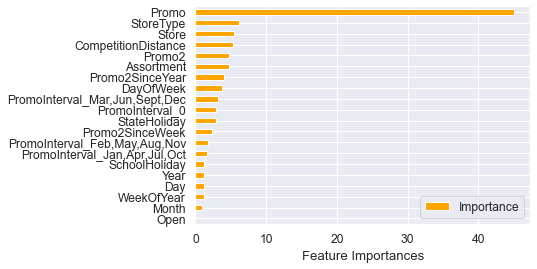

In [113]:
importance.sort_values(by = "Importance", axis = 0 , ascending = True).plot(kind = "barh" , color = "orange")
plt.xlabel("Feature Importances");